In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 (本番用) ---

TRAINING_FILE = "data/processed/training_dataset_hard_negatives_1to3.csv"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"
OUTPUT_MODEL_DIR = "models/sbert_ranknet_v4"

# --- 実験計画からのハイパーパラメータ ---
MAX_LENGTH = 512
LEARNING_RATE = 2e-6
BATCH_SIZE = 16
EPOCHS = 5
GRAD_ACCUM_STEPS = 4  # 勾配を何ステップ分ためてから更新するか
MAX_GRAD_NORM = 1.0

print(f"Configuration set for PRODUCTION (Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS})")

Configuration set for PRODUCTION (Batch Size: 16, Epochs: 5)


In [3]:
# --- 3. カスタムモデルクラスの定義 (CLS Pooling) ---

class SiameseRankNetModel(BertPreTrainedModel):
    """
    S-BERT (RankNet) モデル
    """
    def __init__(self, config):
        super(SiameseRankNetModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        self.classifier_head = nn.Sequential(
            nn.Linear(config.hidden_size * 4, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, 1) # 最終的に1つのスコアを出力
        )
        self.init_weights()
    
    def _get_vector(self, input_ids, attention_mask):
        """SciBERTとCLSプーリングを実行するヘルパー関数"""
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output # CLSトークンのベクトル

    def _calculate_score(self, vec_a, vec_b):
        """2つのベクトルから1つのスコアを計算するヘルパー関数"""
        diff = torch.abs(vec_a - vec_b)
        prod = vec_a * vec_b
        features = torch.cat([vec_a, vec_b, diff, prod], dim=1)
        return self.classifier_head(features)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_positive=None,
        attention_mask_positive=None,
        input_ids_negative=None,
        attention_mask_negative=None,
        labels=None,
        **kwargs
    ):
        vec_anchor = self._get_vector(input_ids, attention_mask)
        vec_positive = self._get_vector(input_ids_positive, attention_mask_positive)
        vec_negative = self._get_vector(input_ids_negative, attention_mask_negative)

        score_positive = self._calculate_score(vec_anchor, vec_positive)
        score_negative = self._calculate_score(vec_anchor, vec_negative)

        return SequenceClassifierOutput(
            loss=None,
            logits=(score_positive, score_negative),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'SiameseRankNetModel' (CLS Pooling) defined.")

Custom model class 'SiameseRankNetModel' (CLS Pooling) defined.


In [4]:
# --- 4. データセットの読み込みとTripletへの変換 ---
print(f"Loading full dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# 全データセットを正例ペアと負例ペアに分割
pos_df = df_full[df_full['label'] == 1]
neg_df = df_full[df_full['label'] == 0]

if pos_df.empty or neg_df.empty:
    raise ValueError("Full dataset must contain both positive and negative samples.")

# --- Tripletの作成 ---
print("Creating triplets from full dataset...")
triplets = []
negative_abstracts = neg_df['abstract_b'].tolist()

for index, row in tqdm(pos_df.iterrows(), total=len(pos_df), desc="Creating Triplets"):
    anchor = row['abstract_a']
    positive = row['abstract_b']
    negative = np.random.choice(negative_abstracts)
    
    triplets.append({
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    })

df_triplets = pd.DataFrame(triplets)
# Trainerの評価ループを動作させるため、ダミーのlabels列を追加
df_triplets['labels'] = 0
print(f"Created {len(df_triplets)} triplets.")

# Triplet形式のデータセットをHugging Face形式に変換
raw_dataset = Dataset.from_pandas(df_triplets)
# 本番なので、検証データ(validation)も多め(20%)に確保
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Triplet dataset loaded: {dataset}")

Loading full dataset: data/processed/training_dataset_hard_negatives_1to3.csv
Full dataset size: 28052
Creating triplets from full dataset...


Creating Triplets:   0%|          | 0/7013 [00:00<?, ?it/s]

Created 7013 triplets.
Triplet dataset loaded: DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 5610
    })
    validation: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 1403
    })
})


In [5]:
# --- 5. トークナイズ処理 (Triplet用) ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_triplet_function(examples):
    tokenized_anchor = tokenizer(examples["anchor"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_positive = tokenizer(examples["positive"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_negative = tokenizer(examples["negative"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    
    return {
        "input_ids": tokenized_anchor["input_ids"],
        "attention_mask": tokenized_anchor["attention_mask"],
        "input_ids_positive": tokenized_positive["input_ids"],
        "attention_mask_positive": tokenized_positive["attention_mask"],
        "input_ids_negative": tokenized_negative["input_ids"],
        "attention_mask_negative": tokenized_negative["attention_mask"],
    }

print("Tokenizing triplet dataset...")
tokenized_datasets = dataset.map(tokenize_triplet_function, batched=True, num_proc=4,
                                 remove_columns=["anchor", "positive", "negative"])
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing triplet dataset...


Map (num_proc=4):   0%|          | 0/5610 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1403 [00:00<?, ? examples/s]

Tokenization complete.


In [6]:
# --- 6. カスタムTrainerの定義 ---

class RankNetTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = nn.BCEWithLogitsLoss()
        print(f"RankNetTrainer initialized with BCEWithLogitsLoss.")

    def compute_loss(self, model, inputs, return_outputs=False):
        if "labels" in inputs:
            inputs.pop("labels")
            
        outputs = model(**inputs)
        score_positive, score_negative = outputs.logits
        
        score_diff = score_positive - score_negative
        target = torch.ones_like(score_diff, dtype=torch.float)
        loss = self.loss_fct(score_diff, target)

        return (loss, outputs) if return_outputs else loss

print("Custom 'RankNetTrainer' defined.")

Custom 'RankNetTrainer' defined.


In [7]:
# --- 7. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
model = SiameseRankNetModel.from_pretrained(MODEL_CHECKPOINT, num_labels=1).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数 (RankNet Accuracy)
def compute_metrics_ranknet(eval_pred):
    score_pos, score_neg = eval_pred.predictions
    preds = (score_pos.squeeze() > score_neg.squeeze())
    accuracy = preds.mean().item()
    return {'rank_accuracy': accuracy}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, # 32
    per_device_eval_batch_size=BATCH_SIZE, # 32
    num_train_epochs=EPOCHS,               # 5
    weight_decay=0.01,
    evaluation_strategy="steps", 
    eval_steps=50,
    save_strategy="steps",   
    save_steps=250,
    load_best_model_at_end=True, # 最高のモデルを最後にロード
    logging_strategy="steps",
    logging_steps=50,           # 50ステップごとにログ表示
    warmup_ratio=0.1,            # 10%ウォームアップ
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    max_grad_norm=MAX_GRAD_NORM,
)
print("Training arguments set for PRODUCTION.")

Loading custom model: allenai/scibert_scivocab_uncased


Some weights of SiameseRankNetModel were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier_head.0.bias', 'classifier_head.0.weight', 'classifier_head.2.bias', 'classifier_head.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom model loaded.
Training arguments set for PRODUCTION.


In [8]:
# --- 8. 訓練の開始 ---
from torch.optim import AdamW

# --- 学習率の個別設定 ---
# 1. BERT部分のパラメータ（学習率: 小）
bert_params = list(model.bert.named_parameters())
# 2. 分類ヘッド部分のパラメータ（学習率: 大）
classifier_params = list(model.classifier_head.named_parameters())

# グループ化
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in bert_params],
        "lr": LEARNING_RATE, # 元の設定 (2e-5)
    },
    {
        "params": [p for n, p in classifier_params],
        "lr": 2e-5,
    },
]

# カスタムオプティマイザの作成
optimizer = AdamW(optimizer_grouped_parameters)

# Trainerの初期化 (optimizers引数を使用)
trainer = RankNetTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_ranknet,
    # ▼▼▼ 修正点: カスタムオプティマイザを渡す ▼▼▼
    # (スケジューラはNoneにしておくと、Trainerがデフォルトのものを作成してくれます)
    optimizers=(optimizer, None)
)

print("\n--- Starting Model Training (RankNet Loss PRODUCTION, Differential Learning Rates) ---")
trainer.train()
print("--- Model Training Complete ---")

RankNetTrainer initialized with BCEWithLogitsLoss.

--- Starting Model Training (RankNet Loss PRODUCTION, Differential Learning Rates) ---


Step,Training Loss,Validation Loss,Rank Accuracy
50,0.680400,0.642009,0.721311
100,0.586000,0.463740,0.837491
150,0.412900,0.325029,0.878118
200,0.305900,0.245753,0.914469
250,0.247800,0.194293,0.935852
300,0.196500,0.163991,0.941554
350,0.180300,0.147222,0.950107
400,0.153400,0.137475,0.955809


--- Model Training Complete ---


In [9]:
# --- 9. モデル、学習ログ、ハイパーパラメータの保存 ---
import json
import os

print("Training complete. Saving artifacts...")

# 1. ベストモデルの保存
# (ここで training_args.bin も best_model/ 内に自動保存されます)
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

# 2. 学習ログ(log_history)の取得
log_history = trainer.state.log_history

# 3. ログをCSVとして保存
df_log = pd.DataFrame(log_history)
log_csv_path = os.path.join(OUTPUT_MODEL_DIR, "training_logs.csv")
df_log.to_csv(log_csv_path, index=False)
print(f"Training logs (CSV) saved to {log_csv_path}")

# 4. ログをJSONとして保存
log_json_path = os.path.join(OUTPUT_MODEL_DIR, "training_logs.json")
with open(log_json_path, "w") as f:
    json.dump(log_history, f, indent=2)
print(f"Training logs (JSON) saved to {log_json_path}")

# 5. ▼▼▼ 追加: ハイパーパラメータをJSONとして保存 ▼▼▼
# (training_argsオブジェクトを辞書に変換して保存)
args_json_path = os.path.join(OUTPUT_MODEL_DIR, "training_args.json")
with open(args_json_path, "w") as f:
    json.dump(trainer.args.to_dict(), f, indent=2)
print(f"Hyperparameters (JSON) saved to {args_json_path}")

Training complete. Saving artifacts...
Model saved to models/sbert_ranknet_v4/best_model
Training logs (CSV) saved to models/sbert_ranknet_v4/training_logs.csv
Training logs (JSON) saved to models/sbert_ranknet_v4/training_logs.json
Hyperparameters (JSON) saved to models/sbert_ranknet_v4/training_args.json



--- Visualizing Training Results ---
Columns in df_eval: ['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss', 'eval_rank_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']


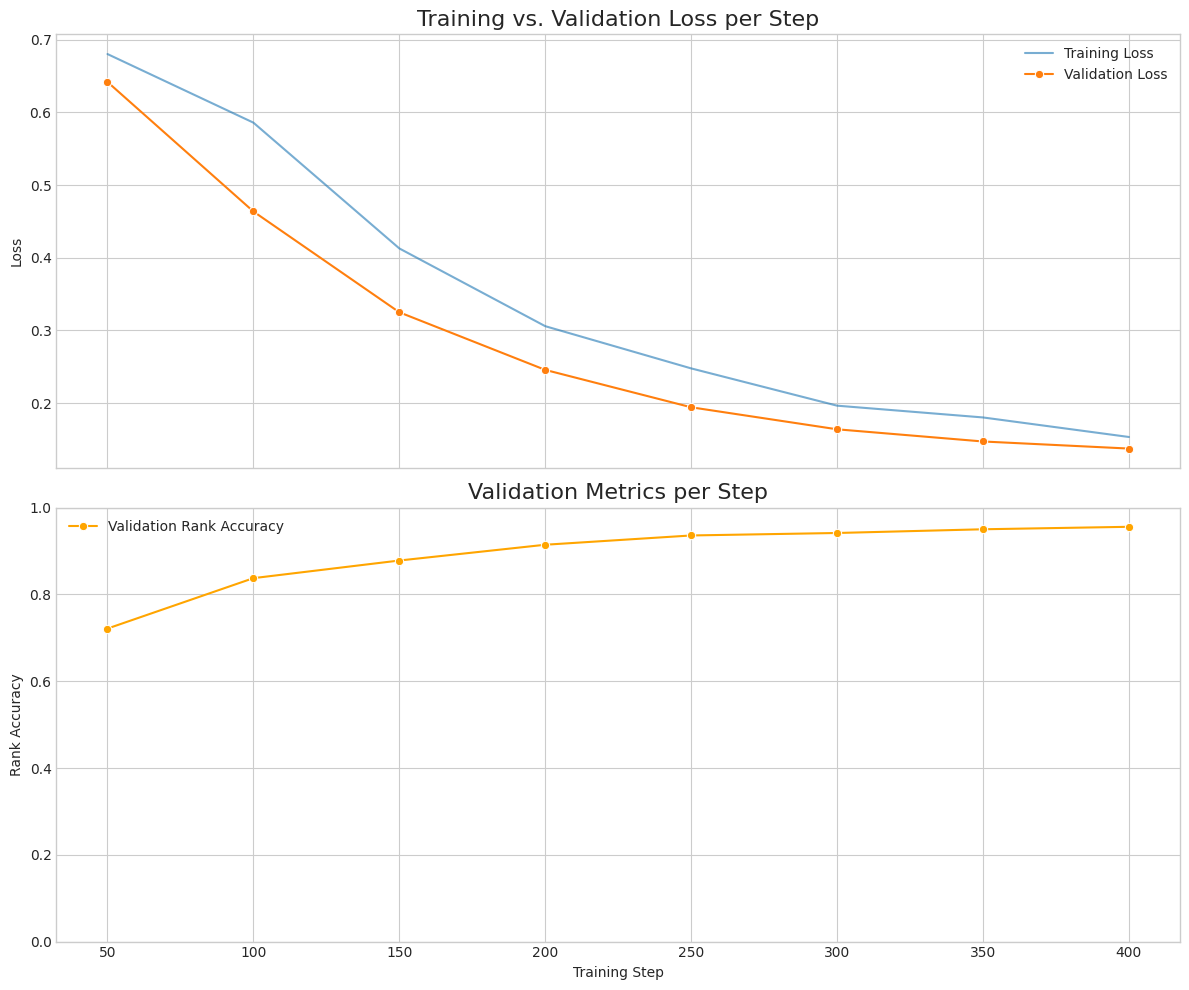


--- Best Model Evaluation Metrics (from validation set) ---
Best Step: 400.0
Best Validation Loss: 0.1375
Best Validation Rank Accuracy: 0.9558


In [12]:
# --- 10. 訓練結果の可視化 (RankNet対応版) ---
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

# 利用可能なカラムを確認（念のため表示）
print("Columns in df_eval:", df_eval.columns.tolist())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

# --- グラフ1: 損失 (Loss) ---
if not df_train.empty and 'loss' in df_train.columns:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1, alpha=0.6)
if not df_eval.empty and 'eval_loss' in df_eval.columns:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o', markersize=6)

ax1.set_title('Training vs. Validation Loss per Step', fontsize=16)
ax1.set_ylabel('Loss')
ax1.legend()

# --- グラフ2: 評価指標 (Rank Accuracy) ---
# ▼▼▼ 修正点: RankNet用の 'eval_rank_accuracy' をプロット ▼▼▼
if not df_eval.empty and 'eval_rank_accuracy' in df_eval.columns:
    sns.lineplot(data=df_eval, x='step', y='eval_rank_accuracy', label='Validation Rank Accuracy', ax=ax2, marker='o', color='orange', markersize=6)
    
    ax2.set_title('Validation Metrics per Step', fontsize=16)
    ax2.set_ylabel('Rank Accuracy') # ラベルも変更
    ax2.set_xlabel('Training Step')
    ax2.legend()
    ax2.set_ylim(0, 1)
else:
    ax2.set_title('No Rank Accuracy Metric Found', fontsize=16)

plt.tight_layout()
plt.show()

# --- ベストモデルの表示 ---
print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty and 'eval_loss' in df_eval.columns:
    try:
        best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
        print(f"Best Step: {best_run.get('step', 'N/A')}")
        print(f"Best Validation Loss: {best_run.get('eval_loss', -1):.4f}")
        
        if 'eval_rank_accuracy' in best_run:
            print(f"Best Validation Rank Accuracy: {best_run['eval_rank_accuracy']:.4f}")
            
    except Exception as e:
        print(f"Could not determine best run: {e}")
else:
    print("No evaluation steps were completed.")